In [42]:
from functools import partial
from pathlib import Path
import numpy as np
import lnoi400
import gdsfactory as gf
import os
import sys
import importlib
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), "../../scripts/")))
import devices

In [ ]:
@gf.cell
def chip_frame():
    c = gf.get_component("chip_frame", size=(10_000, 5000), center=(0, 0))
    return c

chip_layout = chip_frame()
chip_layout

input_ext = 10.0
double_taper = gf.get_component("double_linear_inverse_taper",
                                input_ext=input_ext,
                                )

trav_wave_eom = devices.tWave_EOM()
lnoi400

x_in = 100
in_loc = np.array([x_in, chip_layout.dymin])
out_loc = np.array([x_in + trav_wave_eom.dxsize + 100, chip_layout.dymax])

ec_in = gf.Component()
ec_ref = ec_in << double_taper
ec_ref.drotate(90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, in_loc + [0.0, 0.5 * input_ext]
)
ec_in.add_ports(ec_ref.ports)

ec_out = gf.Component()
ec_ref = ec_out << double_taper
ec_ref.drotate(-90.0)
ec_ref.dmove(
    ec_ref.ports["o1"].dcenter, out_loc - [0.0, 0.5 * input_ext]
)
ec_out.add_ports(ec_ref.ports)

ecs = {
    "in": ec_in,
    "out": ec_out,
}

In [ ]:
print(devices.tWave_EOM().dcenter[0])

6453.465


In [ ]:
c = gf.Component()


trav_wave_eom_ref = c << trav_wave_eom
print(trav_wave_eom_ref.dcenter[0])
print(trav_wave_eom_ref.dxsize)
print(trav_wave_eom_ref.dxmax)

2602.7795
6453.465
5829.512


In [57]:
c = gf.Component()
trav_wave_eom_ref = c << trav_wave_eom
print(trav_wave_eom_ref.dcenter[0])
print(np.abs(trav_wave_eom_ref.dxmin))
print(chip_layout.dymin)
print(ecs["in"].ports["o1"].dcenter[0])
print(- trav_wave_eom_ref.dcenter[0] + chip_layout.dymin + np.abs(trav_wave_eom_ref.dxmin) + ecs["in"].ports["o1"].dcenter[0])

2602.7795
623.953
-2525.0
100.0
-4403.826500000001


In [60]:
routing_roc = 100.0

@gf.cell
def trave_wave_eom_circuit(
    trav_wave_eom = trav_wave_eom,
    ecs = ecs,
) -> gf.Component:

    c = gf.Component()
    trav_wave_eom_ref = c << trav_wave_eom
    trav_wave_eom_ref.dmovex(- trav_wave_eom_ref.dcenter[0] + chip_layout.dymin + np.abs(trav_wave_eom_ref.dxmin) + ecs["in"].ports["o1"].dcenter[0])
    

    # Bend spec

    routing_bend = partial(
        gf.components.bend_euler,
        radius=routing_roc,
        with_arc_floorplan=True,
    )

    # Routing to I/O

    [c << ec for ec in ecs.values()]

    gf.routing.route_single(
        c,
        trav_wave_eom_ref.ports["o1"],
        ecs["in"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    gf.routing.route_single(
        c,
        trav_wave_eom_ref.ports["o2"],
        ecs["out"].ports["o2"],
        start_straight_length=5.0,
        end_straight_length=5.0,
        cross_section="xs_rwg1000",
        bend=routing_bend,
        straight="straight_rwg1000",
    )

    c.flatten()
    c.add_port(name="o1", port=ecs["in"].ports["o1"])
    c.add_port(name="o2", port=ecs["out"].ports["o1"])

    return c

circuit = trave_wave_eom_circuit()
circuit.show()

' _ = die.write_gds(gdsdir=Path.cwd()) '

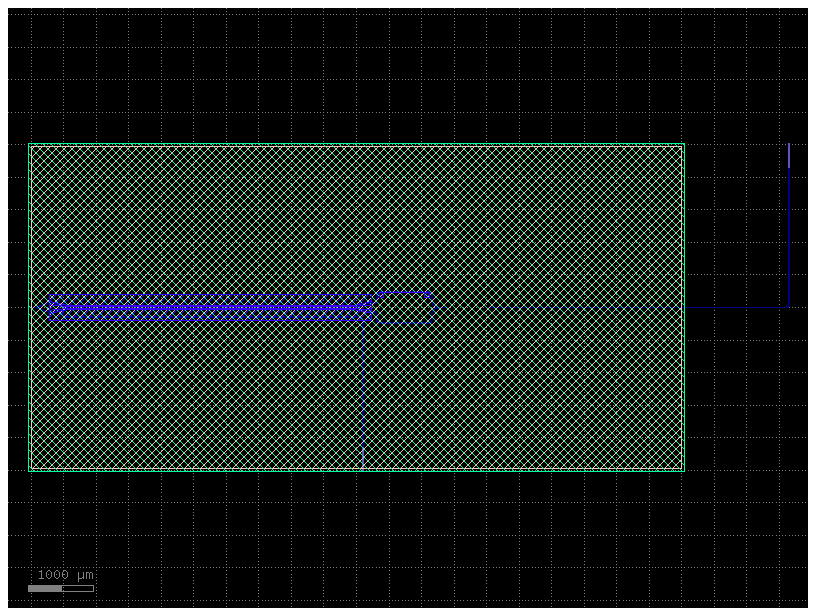

In [61]:
@gf.cell
def die_assembled(
    chip_layout = chip_layout,
    circuit = circuit,
) -> gf.Component:
    c = gf.Component()
    c << chip_layout
    c << circuit
    c.add_ports(circuit.ports)
    return c

die = die_assembled()
die.plot()
die.show()
""" _ = die.write_gds(gdsdir=Path.cwd()) """

In [7]:
die.pprint_ports()

┏━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ name ┃ width ┃ orientation ┃ layer         ┃ center             ┃ port_type ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ o1   │ 0.25  │ 90.0        │ LN_SLAB (3/0) │ (-4050.0, 2530.0)  │ optical   │
│ o2   │ 0.25  │ 270.0       │ LN_SLAB (3/0) │ (-3800.0, -2530.0) │ optical   │
└──────┴───────┴─────────────┴───────────────┴────────────────────┴───────────┘

In [58]:
gf.clear_cache()